# 🚗 **Vehicle Clustering Analysis**

## **Objective:**

Cluster vehicles based on technical and performance features to identify groups of similar vehicles. This helps automobile manufacturers understand which existing models are closest to a new prototype, informing competitive analysis and supply decisions.

In [6]:
# 1. Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score

In [7]:
# 2. Load Dataset

# Load dataset (replace with your file path if not using Colab)
df = pd.read_csv("Cars.csv")

# Quick overview
df.info()
print("Missing values in dataset:", df.isnull().values.any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   manufact   156 non-null    object 
 1   model      156 non-null    object 
 2   sales      156 non-null    float64
 3   resale     156 non-null    float64
 4   type       156 non-null    int64  
 5   price      156 non-null    float64
 6   engine_s   156 non-null    float64
 7   horsepow   156 non-null    int64  
 8   wheelbas   156 non-null    float64
 9   width      156 non-null    float64
 10  length     156 non-null    float64
 11  curb_wgt   156 non-null    float64
 12  fuel_cap   156 non-null    float64
 13  mpg        156 non-null    float64
 14  lnsales    156 non-null    float64
 15  partition  156 non-null    int64  
dtypes: float64(11), int64(3), object(2)
memory usage: 19.6+ KB
Missing values in dataset: False


In [8]:
# 3. Feature Selection

# We'll use the following numerical features for clustering:
# engine_s, horsepow, wheelbas, width, length, curb_wgt, fuel_cap,

features = ['engine_s', 'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap', 'mpg']
X = df[features]

# Check missing values
print(X.isnull().sum())

engine_s    0
horsepow    0
wheelbas    0
width       0
length      0
curb_wgt    0
fuel_cap    0
mpg         0
dtype: int64


In [9]:
# 4. Data Normalization

# Normalization ensures that all features contribute equally to distance calculations.
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)
X_scaled.head()

,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg
0,0.114286,0.215190,0.186551,0.271676,0.306258,0.202339,0.133641,0.433333
1,0.314286,0.430380,0.336226,0.445087,0.579228,0.441120,0.317972,0.333333
2,0.314286,0.430380,0.310195,0.462428,0.567244,0.428338,0.317972,0.366667
3,0.357143,0.392405,0.477223,0.508671,0.628495,0.531683,0.354839,0.233333
4,0.114286,0.240506,0.216920,0.323699,0.380826,0.299973,0.281106,0.400000


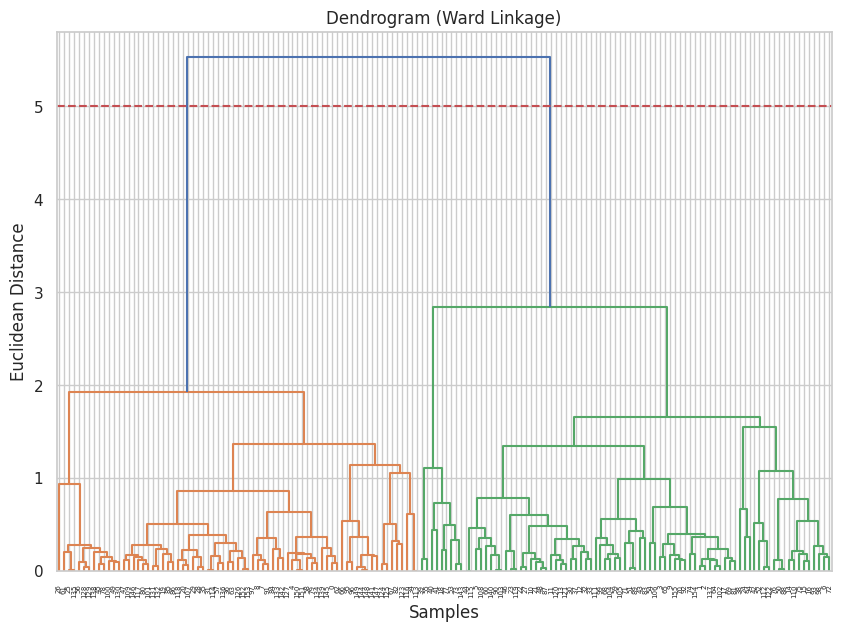

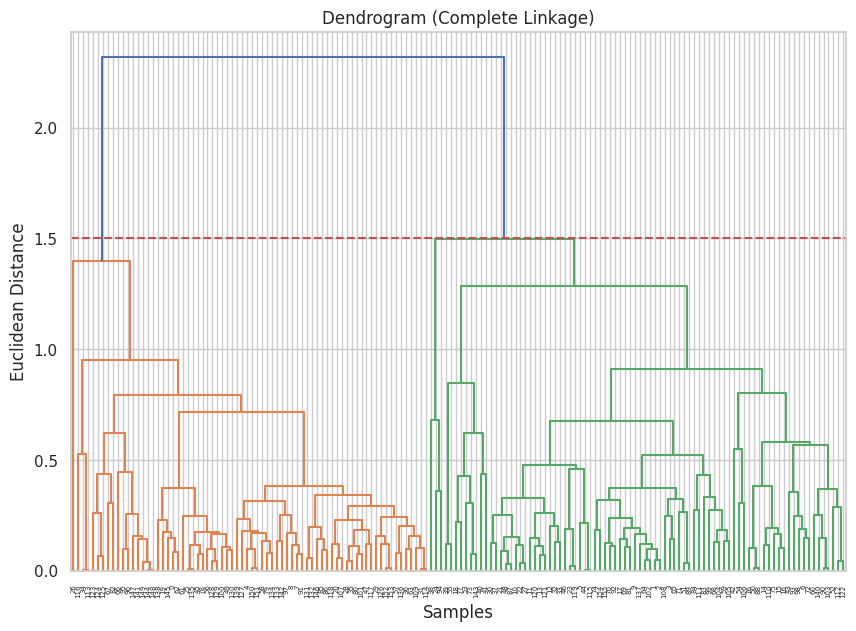

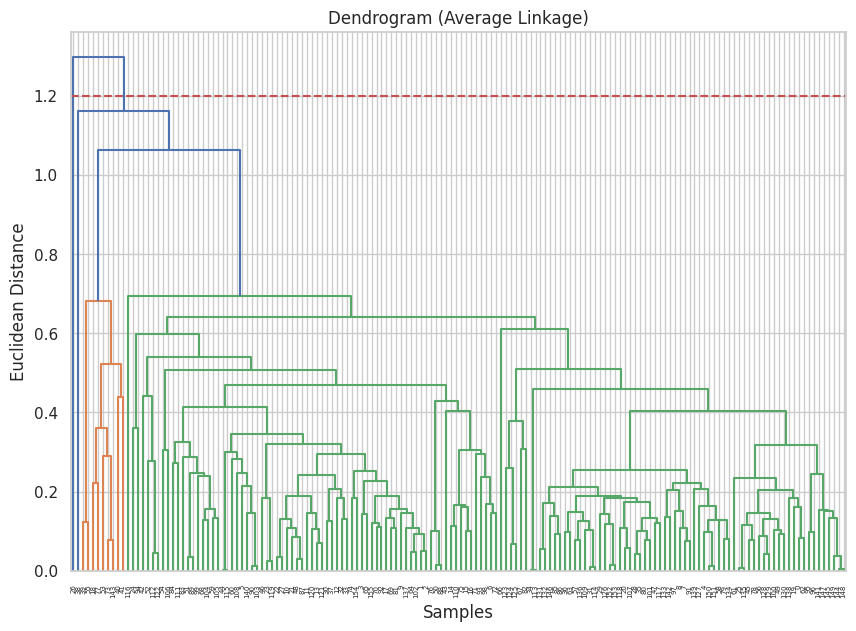

In [10]:
# 5. Hierarchical Clustering

# Hierarchical clustering builds a tree of clusters. We explore three linkage methods:
# Ward: minimizes variance within clusters
# Complete: minimizes maximum distance between clusters
# Average: minimizes average distance between clusters

# 5.1 Dendrograms
def plot_dendrogram(X, method, threshold):
    plt.figure(figsize=(10,7))
    dendrogram = sch.dendrogram(sch.linkage(X, method=method))
    plt.axhline(y=threshold, color='r', linestyle='--')
    plt.title(f'Dendrogram ({method.capitalize()} Linkage)')
    plt.xlabel('Samples')
    plt.ylabel('Euclidean Distance')
    plt.show()

# Ward
plot_dendrogram(X_scaled, method='ward', threshold=5.0)

# Complete
plot_dendrogram(X_scaled, method='complete', threshold=1.5)

# Average
plot_dendrogram(X_scaled, method='average', threshold=1.2)

In [11]:
# 5.2 Fit Agglomerative Clustering & Silhouette Score
n_clusters = 2  # Initial guess

linkages = ['ward', 'complete', 'average']
labels_dict = {}
silhouette_scores = {}

for linkage in linkages:
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    labels = model.fit_predict(X_scaled)
    labels_dict[linkage] = labels
    silhouette_scores[linkage] = silhouette_score(X_scaled, labels)

print("Silhouette Scores (2 clusters):")
for link, score in silhouette_scores.items():
    print(f"{link.capitalize()} linkage: {score:.3f}")

Silhouette Scores (2 clusters):
Ward linkage: 0.366
Complete linkage: 0.364
Average linkage: 0.515


In [12]:
# 5.3 Grid-Search-like Evaluation (Silhouette Score)
results = []

for linkage in linkages:
    for k in range(2, 11):
        model = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = model.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        results.append({'linkage': linkage, 'n_clusters': k, 'silhouette_score': score})

results_df = pd.DataFrame(results)
results_df.sort_values(by='silhouette_score', ascending=False).head()

,linkage,n_clusters,silhouette_score
18,average,2,0.514707
19,average,3,0.406647
20,average,4,0.388135
0,ward,2,0.366284
9,complete,2,0.363677


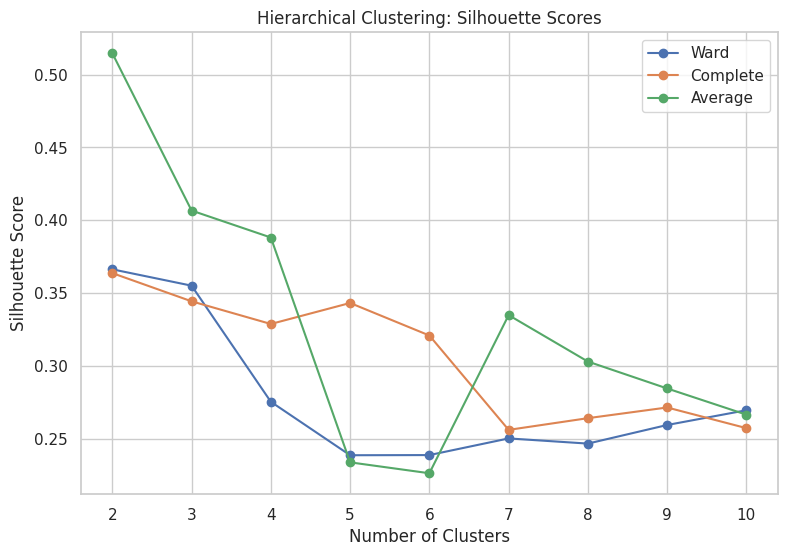

In [13]:
# Plot Silhouette Scores
plt.figure(figsize=(9,6))
for linkage in linkages:
    subset = results_df[results_df['linkage'] == linkage]
    plt.plot(subset['n_clusters'], subset['silhouette_score'], marker='o', label=linkage.capitalize())

plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Hierarchical Clustering: Silhouette Scores')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Fit Best Model
best_params = results_df.loc[results_df['silhouette_score'].idxmax()]
print("Best hierarchical clustering parameters:", best_params)

best_model = AgglomerativeClustering(
    n_clusters=int(best_params['n_clusters']),
    linkage=best_params['linkage']
)
df['Cluster_Hierarchical'] = best_model.fit_predict(X_scaled)

Best hierarchical clustering parameters: linkage              average
n_clusters                 2
silhouette_score    0.514707
Name: 18, dtype: object


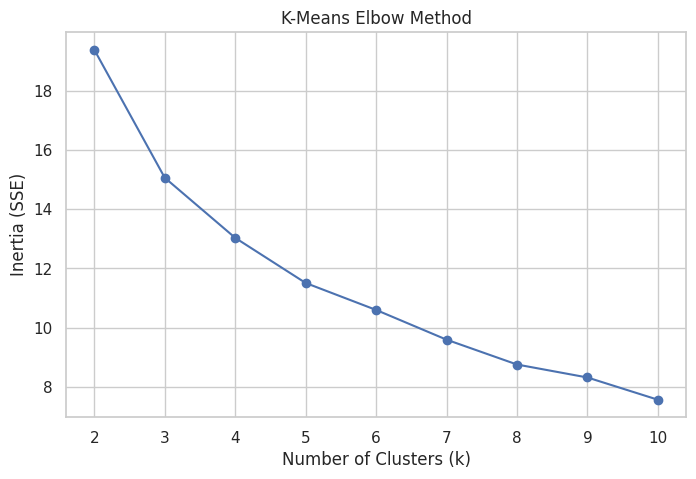

In [15]:
# 6. K-Means Clustering

# 6.1 Elbow Method
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=3, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (SSE)')
plt.title('K-Means Elbow Method')
plt.grid(True)
plt.show()

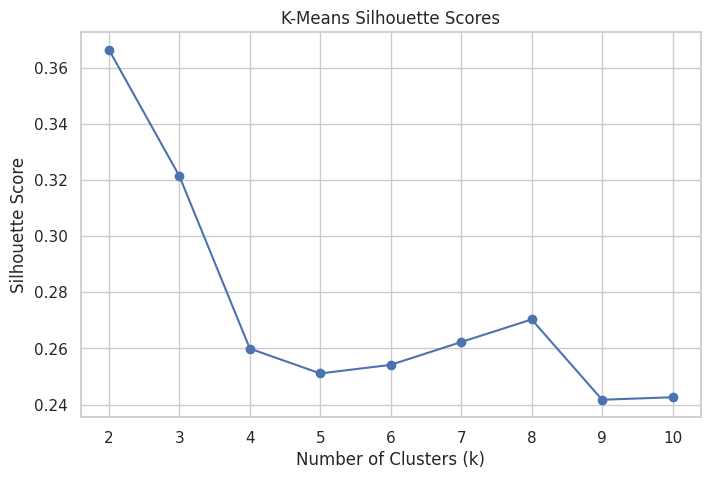

Best number of clusters for K-Means: 2


In [16]:
# 6.2 Silhouette Score Evaluation
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=3, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(8,5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('K-Means Silhouette Scores')
plt.grid(True)
plt.show()

# Best k
best_k = k_range[np.argmax(silhouette_scores)]
print("Best number of clusters for K-Means:", best_k)

In [18]:
# 6.3 Fit Final K-Means
final_kmeans = KMeans(n_clusters=best_k, random_state=3, n_init=10)
df['Cluster_KMeans'] = final_kmeans.fit_predict(X_scaled)

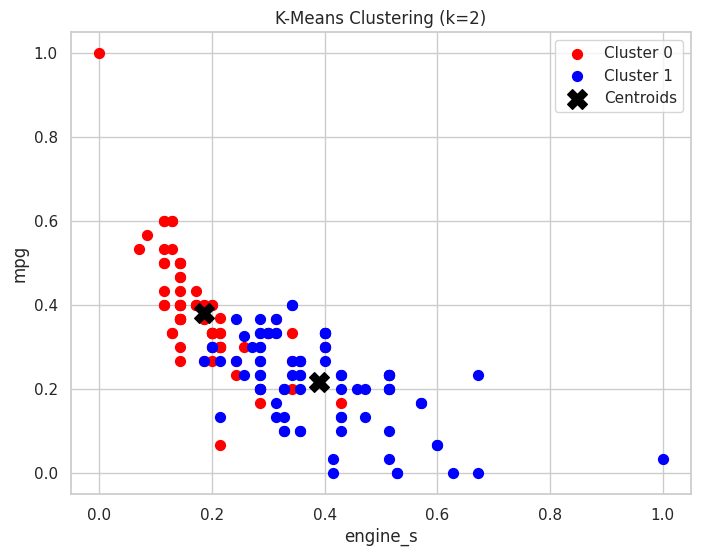

In [19]:
# 6.4 Visualize Clusters (Two Features)
x_feature = "engine_s"
y_feature = "mpg"
x = X_scaled[x_feature]
y = X_scaled[y_feature]
colors = ['red', 'blue', 'green', 'purple', 'orange']

plt.figure(figsize=(8,6))
for cluster in range(best_k):
    plt.scatter(x[df['Cluster_KMeans'] == cluster],
                y[df['Cluster_KMeans'] == cluster],
                s=50,
                c=colors[cluster],
                label=f'Cluster {cluster}')

# Plot centroids
centroids = final_kmeans.cluster_centers_
plt.scatter(centroids[:, X_scaled.columns.get_loc(x_feature)],
            centroids[:, X_scaled.columns.get_loc(y_feature)],
            s=200, c='black', marker='X', label='Centroids')

plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title(f'K-Means Clustering (k={best_k})')
plt.legend()
plt.grid(True)
plt.show()

### 7. **Comparison & Findings**

| Method                 | Silhouette Score |
| ---------------------- | ---------------- |
| Hierarchical (Average) | 0.515            |
| K-Means                | 0.367            |


**Insights:**

- Hierarchical clustering with Average linkage produced better-separated clusters than K-Means.

- K-Means assumes spherical clusters of similar size, which is less suitable for this dataset.

- Clustering results can help manufacturers identify which vehicles are most similar to a new prototype, aiding competitive analysis and supply decisions.